In [1]:
'Imports'
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
import keras.applications
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

Using TensorFlow backend.


In [2]:
'Mounting'
from google.colab import drive
# Dataset is stored at Google Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
'Parameters'
img_shape = (150, 150, 3)
tb_log_dir = 'logs'
num_epochs = 2
num_classes = 6
train_directory = '/content/drive/My Drive/intel-image-classification/seg_train'
test_directory = '/content/drive/My Drive/intel-image-classification/seg_test'
classes = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
reverse_classes = {'glacier':2, 'sea':4, 'buildings':0, 'forest':1, 'street':5, 'mountain':3}
seed = 42

# Make results reproducable
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
random.seed(seed)
tf.set_random_seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

'Util functions'
def clear_folder(folder):
    if os.path.exists(folder):
        for the_file in os.listdir(folder):
            file_path = os.path.join(folder, the_file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                # elif os.path.isdir(file_path): shutil.rmtree(file_path)
            except Exception as e:
                print(e)

In [0]:
'Data pipelining'
import math
import random
from imgaug import augmenters as iaa


def preprocess_image(image_path):
    image = cv2.imread(image_path) #Reading the image (OpenCV) in BGR
    image = cv2.resize(image,(150,150)) #Resize the image
    image = image / 255 # Normalize image to [0,1]
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # convert to grayscale
    return image

def augment_image(images):
    seq = iaa.Sequential([
      iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen), cropped pixels are set black
      iaa.Fliplr(0.5), # horizontally flip 50% of the images
      iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
    ])
    images_aug = seq(images=images)
    return images_aug


def load_train_val_images(directory, classes, val_split):    
    
    imagefilepaths = []
    imagefilepaths_train = []
    imagefilepaths_val = []
    y = []

    assert(val_split) > 0.0
    
    # Get file paths 
    for labels in os.listdir(directory): 

        if os.path.isdir(os.path.join(directory,labels)): # Only consider folders
          
          label = classes[labels]
          for image_file in os.listdir(directory+ '/' + labels):
              imagefilepaths.append(directory+ '/' + labels+'/'+image_file)
              y.append(label)

    assert(len(imagefilepaths)) > 0

    # Shuffle before loading images is more efficient
    zipped = list(zip(imagefilepaths, y)) #zipped list means same shuffle order for imagefilepaths and y
    random.shuffle(zipped)
    imagefilepaths, y = zip(*zipped)

    # Split into test and validation split
    split_idx = math.floor(val_split * len(imagefilepaths))
    imagefilepaths_val = imagefilepaths[:split_idx]
    valy = np.array(y[:split_idx]) 
    imagefilepaths_train = imagefilepaths[split_idx:]
    trainy = np.array(y[split_idx:]) 

    # RAM reasons
    imagefilepaths = None
    y = None
    trainx = []
    valx = []
  
    # Load images
    for i, image_path in enumerate(imagefilepaths_train):
        image = preprocess_image(image_path)
        trainx.append(image)
        if i % 1000 == 999 :
            print('Preprocessing train image ' + str(i) + ' of ' + str(len(imagefilepaths_train)))

    for i,image_path in enumerate(imagefilepaths_val):
        image = preprocess_image(image_path)
        valx.append(image)
        if i % 1000 == 999:
            print('Preprocessing val image ' + str(i) + ' of ' + str(len(imagefilepaths_val)))

    np.array(trainx)
    trainx = augment_image(trainx)    # Augment images

    return trainx, trainy, np.array(valx), valy

def load_test_images(directory, classes):
    testx = []
    testy = [] 


    for labels in os.listdir(directory):  

      if os.path.isdir(os.path.join(directory,labels)): # Only consider folders
        label = classes[labels]
        print(labels)

        for image_file in os.listdir(directory+ '/' + labels): #Extracting the file name of the image from Class Label folder
            image = preprocess_image(directory+ '/' + labels + '/' + image_file)
            testx.append(image)
            testy.append(label)
  

    return testx, testy

random.seed(seed)
xtrain, ytrain, xval, yval = load_train_val_images(train_directory, reverse_classes, 0.25)
np.save(train_directory+ '/trainxdata2.npy', xtrain)
np.save(train_directory+ '/trainydata2.npy', ytrain)
np.save(train_directory+ '/valxdata2.npy', xval)
np.save(train_directory+ '/valydata2.npy', yval)
xtest, ytest = load_test_images(test_directory, reverse_classes)
np.save(test_directory+ '/testxdata2.npy', xtest)
np.save(test_directory+ '/testydata2.npy', ytest)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-8617fca41a08>", line 99, in <module>
    xtrain, ytrain, xval, yval = load_train_val_images(train_directory, reverse_classes, 0.25)
  File "<ipython-input-5-8617fca41a08>", line 63, in load_train_val_images
    image = preprocess_image(image_path)
  File "<ipython-input-5-8617fca41a08>", line 8, in preprocess_image
    image = cv2.imread(image_path) #Reading the image (OpenCV) in BGR
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, an

KeyboardInterrupt: ignored

In [0]:
'Model'
def build_model():

    basemodel = keras.applications.vgg16.VGG16(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg')

    #for layer in basemodel.layers:
    #    layer.trainable = False

    basemodel.summary()
  
    model = Sequential()
    model.add(basemodel)
    '''
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape =img_shape, padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size = (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    '''
    # >90 % Acc with 2048, 0.4, 512, 0.4
    model.add(Dense(2048, activation= 'relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(512, activation= 'relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    return model

(10542, 150, 150, 3)
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 

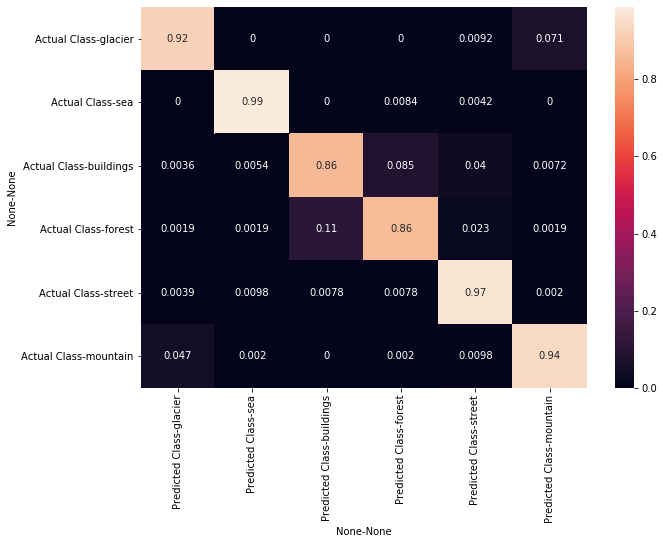

In [7]:
'Training, Validation and Tests'
# %tensorboard --logdir logs -> not working 
batch_size = 32

# Loading Data
xtrain = np.load(train_directory+ '/trainxdata2.npy') 
ytrain = np.load(train_directory+ '/trainydata2.npy')
xval = np.load(train_directory+ '/valxdata2.npy')
yval = np.load(train_directory+ '/valydata2.npy')
xtest = np.load(test_directory+ '/testxdata2.npy')
ytest = np.load(test_directory+ '/testydata2.npy')

print(xtrain.shape)

ytrain = keras.utils.to_categorical(ytrain)
yval = keras.utils.to_categorical(yval)
ytest = keras.utils.to_categorical(ytest)

# Tensorboard and Checkpoints
clear_folder(tb_log_dir)
tensorboard = TensorBoard(log_dir=tb_log_dir)
checkpoint = ModelCheckpoint(train_directory+ 'weights.hdf5', monitor='val_accuracy', verbose=1)

# Training
model = build_model()
optimizer = optimizers.Adam(lr=1e-5)
# Labels are one hot encoded -> categorical crossentropy
model.compile(loss="categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model.fit(xtrain, ytrain, epochs=5, batch_size=32, validation_data =(xval, yval), shuffle=True, callbacks=[tensorboard, checkpoint])

# Prediction
prediction = model.predict(xtest)
acc = accuracy_score(y_true = np.argmax(ytest, axis = -1), y_pred = np.argmax(prediction, axis = -1), normalize = True)
print(acc)

# Confusion matrix
class_labels = list(reverse_classes.keys())
confusion = confusion_matrix(y_true = np.argmax(ytest, axis = -1), y_pred = np.argmax(prediction, axis = -1), normalize= 'true')
df_cm = pd.DataFrame(confusion, index = class_labels,
                  columns = class_labels)
# Add actual/predicted class to labels
df_cm = pd.concat(
    [pd.concat(
        [df_cm],
        keys=['Predicted Class'], axis=1)],
    keys=['Actual Class']
)
# Show confusion matrix
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [0]:
'''# different pipeline needed, because reading images from google drive is really really slow
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    data_format='channels_last',
    validation_split=0.25,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_data = train_datagen.flow_from_directory(
    train_directory,
    target_size=img_shape[:-1], # only height and width
    batch_size=batch_size,
    seed=seed,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb')

test_data = test_datagen.flow_from_directory(
    test_directory,
    target_size=img_shape[:-1], # only height and width
    class_mode='categorical',
    color_mode='rgb')

validation_data = train_datagen.flow_from_directory(
    train_directory, # same directory as training data
    target_size=img_shape[:-1],
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation') # set as validation data'''
